# Galaxy Zoo

<img src="https://raw.githubusercontent.com/illinois-dap/DataAnalysisForPhysicists/main/img/Project_GalaxyZoo-galaxypic.png" width=300 align=left></img><br>

## <span style="color:Orange">Overview</span>

Understanding how and why we are here is one of the fundamental questions for the ages. Part of the answer to this question lies in the origins of galaxies, such as our own Milky Way. Yet questions remain about how the Milky Way (or any of the other ~100 billion galaxies in our Universe) was formed and has evolved. Galaxies come in all shapes, sizes and colors: from beautiful spirals to huge ellipticals. “Kevin Schawinski, previously an astrophysicist at Oxford University and co-founder of Galaxy Zoo, described the problem that led to Galaxy Zoo's creation when he was set the task of classifying the morphology of more than 900,000 galaxies by eye that had been imaged by the Sloan Digital Sky Survey at the Apache Point Observatory in New Mexico, USA.”

## <span style="color:Orange">Data Sources</span>

Original Source
* https://www.kaggle.com/competitions/galaxy-zoo-the-galaxy-challenge/data (requires Kaggle account)

File URLs
* https://courses.physics.illinois.edu/phys503/fa2023/data/projects/GalaxyZoo/all_ones_benchmark.zip
* https://courses.physics.illinois.edu/phys503/fa2023/data/projects/GalaxyZoo/all_zeros_benchmark.zip
* https://courses.physics.illinois.edu/phys503/fa2023/data/projects/GalaxyZoo/central_pixel_benchmark.zip
* https://courses.physics.illinois.edu/phys503/fa2023/data/projects/GalaxyZoo/images_test_rev1.zip
* https://courses.physics.illinois.edu/phys503/fa2023/data/projects/GalaxyZoo/images_training_rev1.zip
* https://courses.physics.illinois.edu/phys503/fa2023/data/projects/GalaxyZoo/training_solutions_rev1.zip

## <span style="color:Orange">Questions</span>

Please refer to the corresponding Project 01 notebook for background questions related to this project. In this project, you are to focused on machine learning application(s).

### <span style="color:LightGreen">Question 01</span>

Each Image is labeled with its GalaxyID. Use the benchmark data set as the classification label. Since the training data is the Image, we could use a Convolutional Neural Network (CNN) architecture to build up the training. What is the input data for your Network? Could you design a simple CNN structure for this training?

## Answer

**Input data**

For each galaxy I build a training pair $(x_i, y_i)$:

- **Image input**:  
  - Load the JPEG image corresponding to the GalaxyID.  
  - Convert to RGB, resize to $64\times 64$, normalize pixels to $[0,1]$.  
  - Store it as a tensor  
    $$x_i \in \mathbb{R}^{3\times 64\times 64}$$  
    (channels, height, width). A mini-batch of size $B$ has shape $[B,3,64,64]$.

- **Label from benchmark data**:  
  - For each GalaxyID the benchmark / solution CSV gives a probability vector  
    $$p_i = (p_{i,1},\dots,p_{i,37})$$  
    across the 37 morphology classes (`Class1.1` … `Class11.6`).  
  - I convert this to a single integer class label by  
    $$y_i = \arg\max_k p_{i,k}, \quad k\in\{1,\dots,37\}.$$  
  - During training I use $y_i$ with a standard multi-class cross-entropy loss.

So the CNN sees only the processed image $x_i$ as input, and the benchmark
probabilities are used to define the target label $y_i$.

---

**Simple CNN structure**

A small CNN that works well on $64\times 64$ RGB images and 37 classes:

1. **Conv block 1**
   - `Conv2d(3, 32, kernel_size=3, padding=1)`  
   - `ReLU`  
   - `MaxPool2d(2)` ( $64\times 64 \rightarrow 32\times 32$ )

2. **Conv block 2**
   - `Conv2d(32, 64, kernel_size=3, padding=1)`  
   - `ReLU`  
   - `MaxPool2d(2)` ( $32\times 32 \rightarrow 16\times 16$ )

3. **Conv block 3**
   - `Conv2d(64, 128, kernel_size=3, padding=1)`  
   - `ReLU`  
   - `MaxPool2d(2)` ( $16\times 16 \rightarrow 8\times 8$ )

4. **Fully connected head**
   - `Flatten()` → vector of length $128 \times 8 \times 8$  
   - `Linear(128*8*8, 256)`, `ReLU`, `Dropout(0.5)`  
   - `Linear(256, 37)` → logits for the 37 morphology classes.

## Cell 1

This cell imports the required libraries, defines two small helper functions (`wget_data` to download files and `locate_data` to find them), then downloads and unzips the four Galaxy Zoo data archives into `./tmp_data`. Finally, it loads the training and benchmark CSV files into `train_sol` and `bench` and prints their shapes / a sample to sanity-check that the data were loaded correctly.

In [14]:
import os
import subprocess

import pandas as pd
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm.auto import tqdm
from IPython.display import display


def wget_data(url: str):
    local_path = './tmp_data'
    os.makedirs(local_path, exist_ok=True)
    p = subprocess.Popen(
        ["wget", "-nc", "-P", local_path, url],
        stderr=subprocess.PIPE,
        encoding='utf-8'
    )
    rc = None
    while rc is None:
        line = p.stderr.readline().strip('\n')
        if len(line) > 0:
            print(line)
        rc = p.poll()

def locate_data(name, check_exists=True):
    local_path = './tmp_data'
    path = os.path.join(local_path, name)
    if check_exists and not os.path.exists(path):
        raise RuntimeError('No such data file: {}'.format(path))
    return path


BASE = "https://courses.physics.illinois.edu/phys498mlp/sp2025/data/projects/GalaxyZoo"
TRAIN_SOL_URL   = f"{BASE}/training_solutions_rev1.zip"
IMAGES_TRAIN_URL= f"{BASE}/images_training_rev1.zip"
CENTRAL_URL     = f"{BASE}/central_pixel_benchmark.zip"
IMAGES_TEST_URL = f"{BASE}/images_test_rev1.zip"

for url in [TRAIN_SOL_URL, IMAGES_TRAIN_URL, CENTRAL_URL, IMAGES_TEST_URL]:
    wget_data(url)

!unzip -q -o ./tmp_data/training_solutions_rev1.zip  -d ./tmp_data
!unzip -q -o ./tmp_data/images_training_rev1.zip     -d ./tmp_data
!unzip -q -o ./tmp_data/central_pixel_benchmark.zip  -d ./tmp_data
!unzip -q -o ./tmp_data/images_test_rev1.zip         -d ./tmp_data

# Load CSVs
train_sol_path = locate_data("training_solutions_rev1.csv")
train_sol = pd.read_csv(train_sol_path)

bench_path = locate_data("central_pixel_benchmark.csv")
bench = pd.read_csv(bench_path)

print("training_solutions shape:", train_sol.shape)
print("central_pixel_benchmark shape:", bench.shape)
display(train_sol.head())


File ‘./tmp_data/training_solutions_rev1.zip’ already there; not retrieving.
File ‘./tmp_data/images_training_rev1.zip’ already there; not retrieving.
File ‘./tmp_data/central_pixel_benchmark.zip’ already there; not retrieving.
File ‘./tmp_data/images_test_rev1.zip’ already there; not retrieving.
training_solutions shape: (61578, 38)
central_pixel_benchmark shape: (79975, 38)


,GalaxyID,Class1.1,Class1.2,Class1.3,Class2.1,Class2.2,Class3.1,Class3.2,Class4.1,Class4.2,...,Class9.3,Class10.1,Class10.2,Class10.3,Class11.1,Class11.2,Class11.3,Class11.4,Class11.5,Class11.6
0,100008,0.383147,0.616853,0.000000,0.000000,0.616853,0.038452,0.578401,0.418398,0.198455,...,0.000000,0.279952,0.138445,0.000000,0.000000,0.092886,0.0,0.0,0.0,0.325512
1,100023,0.327001,0.663777,0.009222,0.031178,0.632599,0.467370,0.165229,0.591328,0.041271,...,0.018764,0.000000,0.131378,0.459950,0.000000,0.591328,0.0,0.0,0.0,0.000000
2,100053,0.765717,0.177352,0.056931,0.000000,0.177352,0.000000,0.177352,0.000000,0.177352,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,100078,0.693377,0.238564,0.068059,0.000000,0.238564,0.109493,0.129071,0.189098,0.049466,...,0.000000,0.094549,0.000000,0.094549,0.189098,0.000000,0.0,0.0,0.0,0.000000
4,100090,0.933839,0.000000,0.066161,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000


## Cell 2

This cell turns the raw Galaxy Zoo files into PyTorch-ready data. It first builds an index from `GalaxyID` to image path, then `build_galaxy_dataset` loads each image, resizes/normalizes it, converts the 37-class probability vector into an integer label via `argmax`, and packs everything into a `TensorDataset`. Finally, it splits this dataset into train/validation subsets and wraps them in `DataLoader`s (`train_loader` and `val_loader`) for mini-batch training.


In [16]:
# Build an index from GalaxyID string -> image path
def build_image_index(images_root: str):
    index = {}
    for root, dirs, files in os.walk(images_root):
        for fname in files:
            if fname.lower().endswith(".jpg"):
                base = os.path.splitext(fname)[0]  # e.g. "100023"
                full_path = os.path.join(root, fname)
                index[base] = full_path
    print(f"Found {len(index)} jpg files under {images_root}")
    return index


# Generic function: build dataset from (images_root, dataframe)
# dataframe must have 'GalaxyID' + Class* columns
def build_galaxy_dataset(images_root, df, img_size=64, max_samples=None):
    img_index = build_image_index(images_root)
    if len(img_index) == 0:
        raise RuntimeError(
            f"No jpg files found under {images_root}. "
            "Check the unzip path and directory name."
        )

    # All "Class*" columns are probabilities for morphology classes
    class_cols = [c for c in df.columns if c.startswith("Class")]
    probs = df[class_cols].values.astype(np.float32)  # [N, num_classes]
    labels = probs.argmax(axis=1).astype(np.int64)    # [N]

    galaxy_ids = df["GalaxyID"].values

    X_list, y_list = [], []
    matched = 0

    print(f"Building dataset from {images_root} ...")
    for gid, y in tqdm(list(zip(galaxy_ids, labels)), total=len(labels)):
        key = str(int(gid))  # GalaxyID is integer-like (e.g. 100023)

        if key not in img_index:
            continue

        img_path = img_index[key]
        img = Image.open(img_path).convert("RGB")
        img = img.resize((img_size, img_size))
        arr = np.asarray(img, dtype=np.float32) / 255.0   # [H,W,3] in [0,1]
        arr = np.transpose(arr, (2, 0, 1))                # -> [3,H,W]

        X_list.append(arr)
        y_list.append(y)
        matched += 1

        if (max_samples is not None) and (len(X_list) >= max_samples):
            break

    print(f"Matched {matched} rows of the dataframe to image files.")

    if len(X_list) == 0:
        raise RuntimeError("No images matched any GalaxyID; something is wrong with paths.")

    X = np.stack(X_list, axis=0)          # [N,3,H,W]
    y = np.array(y_list, dtype=np.int64)  # [N]

    print(f"Loaded {X.shape[0]} images, tensor shape = {X.shape}")

    X_tensor = torch.tensor(X)
    y_tensor = torch.tensor(y)

    dataset = TensorDataset(X_tensor, y_tensor)
    num_classes = len(class_cols)
    return dataset, num_classes, class_cols


# Build TRAIN dataset: images_training_rev1 + training_solutions_rev1.csv
train_images_root = locate_data("images_training_rev1")

train_dataset, num_classes, class_cols = build_galaxy_dataset(
    train_images_root,
    train_sol,
    img_size=64,
    max_samples=None   # use ALL training images
)

print("num_classes:", num_classes)

def split_dataset(dataset, val_fraction=0.2, seed=42):
    N = len(dataset)
    indices = list(range(N))
    rng = np.random.default_rng(seed)
    rng.shuffle(indices)

    val_size = int(N * val_fraction)
    val_idx = indices[:val_size]
    train_idx = indices[val_size:]

    train_subset = torch.utils.data.Subset(dataset, train_idx)
    val_subset = torch.utils.data.Subset(dataset, val_idx)
    return train_subset, val_subset

train_ds, val_ds = split_dataset(train_dataset, val_fraction=0.2, seed=0)

batch_size = 64
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  drop_last=False)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, drop_last=False)

print("Train size:", len(train_ds), "Val size:", len(val_ds))


Found 61578 jpg files under ./tmp_data/images_training_rev1
Building dataset from ./tmp_data/images_training_rev1 ...


  0%|          | 0/61578 [00:00<?, ?it/s]

Matched 61578 rows of the dataframe to image files.
Loaded 61578 images, tensor shape = (61578, 3, 64, 64)
num_classes: 37
Train size: 49263 Val size: 12315


## Cell 3

This cell defines the CNN model architecture (`make_simple_galaxy_cnn`) that maps galaxy images to class logits, and two utility functions `train_one_epoch` and `eval_one_epoch` that run one pass over a `DataLoader` to compute average loss and accuracy for training and validation.


In [18]:
# Simple CNN model 
def make_simple_galaxy_cnn(num_classes: int, img_size: int = 64):
    # Three 2x2 max-pooling layers -> spatial size = img_size / 8
    final_hw = img_size // 8

    model = nn.Sequential(
        # Block 1: 3 -> 32 channels
        nn.Conv2d(3, 32, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2),       # 64x64 -> 32x32

        # Block 2: 32 -> 64 channels
        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2),       # 32x32 -> 16x16

        # Block 3: 64 -> 128 channels
        nn.Conv2d(64, 128, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2),       # 16x16 -> 8x8

        nn.Flatten(),
        nn.Linear(128 * final_hw * final_hw, 256),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.Linear(256, num_classes)  # logits, no softmax
    )
    return model

# Training and evaluation utilities
def train_one_epoch(model, loader, optimizer, loss_fn, device):
    model.train()
    total_loss, correct, total = 0.0, 0, 0

    for x, y in loader:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        logits = model(x)
        loss = loss_fn(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    avg_loss = total_loss / total
    acc = correct / total
    return avg_loss, acc

def eval_one_epoch(model, loader, loss_fn, device):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            logits = model(x)
            loss = loss_fn(logits, y)

            total_loss += loss.item() * x.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)

    avg_loss = total_loss / total
    acc = correct / total
    return avg_loss, acc


## Cell 4

This cell trains the CNN on `train_loader` with `CrossEntropyLoss` and `Adam`, using early stopping based on validation loss from `val_loader`. During training it records train/validation loss and accuracy each epoch, measures total training time, then plots the learning curves (loss and accuracy vs. epoch) and prints a short summary including the number of epochs, the device used (`cpu` or `cuda`), the best validation loss, and the total runtime.


Using device: cpu


Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 01: train_loss=0.9824, train_acc=0.601, val_loss=0.8767, val_acc=0.618, time=115.2s
Epoch 02: train_loss=0.8427, train_acc=0.645, val_loss=0.7590, val_acc=0.690, time=111.7s
Epoch 03: train_loss=0.7498, train_acc=0.699, val_loss=0.6869, val_acc=0.720, time=102.0s
Epoch 04: train_loss=0.6859, train_acc=0.725, val_loss=0.6724, val_acc=0.726, time=102.7s
Epoch 05: train_loss=0.6464, train_acc=0.745, val_loss=0.6395, val_acc=0.742, time=91.8s
Epoch 06: train_loss=0.6140, train_acc=0.757, val_loss=0.6164, val_acc=0.751, time=91.5s
Epoch 07: train_loss=0.5862, train_acc=0.767, val_loss=0.6387, val_acc=0.749, time=96.7s
Epoch 08: train_loss=0.5610, train_acc=0.779, val_loss=0.6098, val_acc=0.757, time=96.5s
Epoch 09: train_loss=0.5378, train_acc=0.789, val_loss=0.6469, val_acc=0.748, time=90.6s
Epoch 10: train_loss=0.5089, train_acc=0.799, val_loss=0.6420, val_acc=0.751, time=88.7s
Epoch 11: train_loss=0.4871, train_acc=0.808, val_loss=0.6580, val_acc=0.748, time=89.1s
Epoch 12: train_l

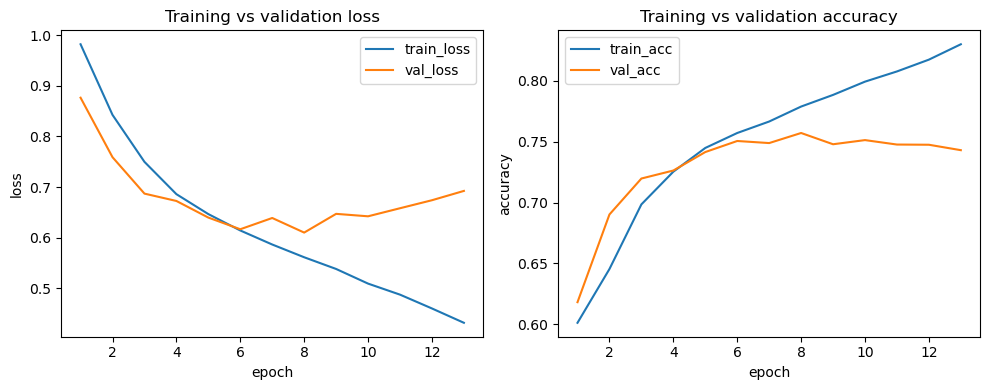

Summary: trained CNN for 13 epochs on cpu, best val_loss = 0.6098, total time = 20.77 minutes.


In [20]:
import copy
import time
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = make_simple_galaxy_cnn(num_classes=num_classes, img_size=64).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Early-stopping settings
max_epochs = 50
patience   = 5
min_delta  = 1e-4

best_val_loss     = float("inf")
best_state_dict   = None
epochs_no_improve = 0

# History
train_loss_hist, val_loss_hist = [], []
train_acc_hist,  val_acc_hist  = [], []

start_time = time.time()

# Epoch loop with simple progress bar
for epoch in tqdm(range(1, max_epochs + 1), desc="Epochs"):
    t0 = time.time()

    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, loss_fn, device)
    val_loss,   val_acc   = eval_one_epoch(model, val_loader,   loss_fn, device)

    epoch_time = time.time() - t0

    print(
        f"Epoch {epoch:02d}: "
        f"train_loss={train_loss:.4f}, train_acc={train_acc:.3f}, "
        f"val_loss={val_loss:.4f}, val_acc={val_acc:.3f}, "
        f"time={epoch_time:.1f}s"
    )

    # Save history
    train_loss_hist.append(train_loss)
    val_loss_hist.append(val_loss)
    train_acc_hist.append(train_acc)
    val_acc_hist.append(val_acc)

    # Early stopping check
    if val_loss < best_val_loss - min_delta:
        best_val_loss   = val_loss
        best_state_dict = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered (no val_loss improvement for {patience} epochs).")
            break

total_time_sec = time.time() - start_time
num_epochs_run = len(train_loss_hist)

# Load best model
if best_state_dict is not None:
    model.load_state_dict(best_state_dict)
    print(f"Loaded best model with val_loss={best_val_loss:.4f}")

print(
    f"\nTraining ran for {num_epochs_run} epochs on {device} "
    f"in {total_time_sec/60:.2f} minutes ({total_time_sec:.1f} seconds)."
)

# ---- Plot learning curves ----
epochs = range(1, num_epochs_run + 1)

plt.figure(figsize=(10, 4))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_hist, label="train_loss")
plt.plot(epochs, val_loss_hist,   label="val_loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Training vs validation loss")
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_hist, label="train_acc")
plt.plot(epochs, val_acc_hist,   label="val_acc")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("Training vs validation accuracy")
plt.legend()

plt.tight_layout()
plt.show()

print(
    f"Summary: trained CNN for {num_epochs_run} epochs on {device}, "
    f"best val_loss = {best_val_loss:.4f}, "
    f"total time = {total_time_sec/60:.2f} minutes."
)


## Summary of results

The CNN trains for 13 epochs on CPU before early stopping, taking about 21 minutes in total. Training loss decreases from ≈0.98 to ≈0.43 and training accuracy increases from ≈0.60 to ≈0.83, while validation accuracy rises quickly and then stabilizes around 0.74–0.75. The best model (which we reload at the end) has validation loss ≈0.61 and validation accuracy ≈0.75, meaning the network correctly predicts the Galaxy Zoo label for roughly three-quarters of the validation images, with mild overfitting after about 7–8 epochs.


---

## <span style="color:Orange">References</span>

__[<span style="color:Red">1</span>]__ K.W. Willet, _et.al_, "Galaxy Zoo 2: detailed morphological classifications for 304,122 galaxies from the Sloan Digital Sky Survey", _Mon.Not.Roy.Astron.Soc_. 435 (2013) 2835, e-Print: [1308.3496](https://arxiv.org/abs/1308.3496) [astro-ph.CO]


---

## <span style="color:Orange">Acknowledgements</span>

* Initial version: Mark Neubauer

© Copyright 2023